# Inputting User Data using the Hubble Advanced Spectral Products Script

### <span style="font-weight:normal">This Notebook is designed to walk you through downloading and using the **Hubble Advanced Spectral Products (HASP)** co-add script.</span>

## Learning Goals: 

By the end of this tutorial, you will learn how to:
- Setup a `conda` environment

- Download the HASP wrapper script

- Use `astroquery.mast` to download COS and STIS data

- Run the co-add script

- Examine the co-added output

- Run the scipt with multiple threshold values and examine output


## Table of Contents
**0. [Introduction](#introduction)**

**1. [Downloading HST Spectroscopic Data](#datadownload)**

\- 1.1 [Using `Astroquery` to Download STIS Data](#stisdownload)

**2. [Running the Co-add Script](#runscript)**

**3. [Working with Co-added Data Products](#workwithoutput)**

\- 3.1 [Inspecting the Output Files](#inspectoutput)

\- 3.2 [Viewing Co-added STIS Data](#viewstis)

\- 3.3 [Putting it all together with COS Data](#cos)

**4. [Changing the Threshold Flag](#threshold)**

\- 4.1 [Using `Astroquery` to Download Additional Data](#downloadthresh)

\- 4.2 [Running the Co-add Script with Multiple Threshold Values](#threshscriptrun)

\- 4.3 [Analyzing the Co-added Spectra of Different Threshold Values](#analyzethresh)

<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP) code](https://github.com/spacetelescope/hasp) is a script that co-adds spectra of the same target within programs. This software is able to co-add data taken with the spectrographs onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst); the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hst/hasp) uses this script to co-add these instruments’ data from [The Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) to create high-quality spectra with a broad wavelength coverage (whenever possible from the ultraviolet to the near-infrared) that is publicly available for the scientific community. These custom co-addition notebooks will instruct users on how to produce their own co-adds in cases where the MAST archive data needs special processing or is rejected by the default filters used in the co-add script.

The script first co-adds the observations for each grating for a given program, then it combines all gratings for the observation set. Finally, it co-adds the spectra of each observation set in the program to produce a fully co-added spectra for each target in a program. 

This notebook will show users how to download data from MAST, run the co-add script, understand the output files and inspect the abutted data by plotting flux as a function of wavelength. It will also show users how to change the flux threshold flag.

**Please check out our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook before running this tutorial to learn how to install and run the co-add code.**

### Imports

We will be using multiple libraries to retrieve and analyze data. We will use: 
* `Path.pathlib` to create product and data directories 
* `astroquery.mast Observations` to download COS and STIS data
* `shutil` to perform directory and file operations
* `os` to interact with the operating system
* `astropy.io fits` to work with FITS files
* `matplotlib.pyplot` to plot abutted spectra
* `glob` to work with multiple files in our directories
* `subprocesses` to run our script in the notebook with varying threshold flag values
* `numpy` to help analyze our data
* `scipy.interpolate interp1d` to interpolate our data

We must activate our `conda` environment before we run any code; if you haven't created one with the HASP dependencies, you can checkout our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.

Running the next cell will print your current `conda` environment.

_Note: if the following cell doesn't print your hasp environment, you will have to activate the `conda` environment in your terminal or by running the subsequent cell, and then restart the notebook. This is because of how different shells are configured._

In [1]:
import os
print("Currently active conda environment:", os.environ.get("CONDA_PREFIX"))

Currently active conda environment: None


In [2]:
!conda activate hasp-env

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'activate' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'content-trust', 'doctor', 'repoquery', 'env')


Please make sure the environment that contains the HASP script dependencies is activated, otherwise **_you will NOT be able to run the co-add code._**

Let's import all of our packages that we will use in this notebook:

In [3]:
import os
from pathlib import Path
from astroquery.mast import Observations
import shutil
import glob as glob
from astropy.io import fits
import matplotlib.pyplot as plt
import subprocess
import numpy as np
from scipy.interpolate import interp1d

To do our tutorial, we will create data folders that will contain downloaded data from MAST (one for the STIS and the another for COS). We will also create products folders to contain the HASP script output, a.k.a the co-added spectra. We will have one folder for STIS and another for COS too.

In [4]:
# Creating the data download directories for COS and STIS
stis_data_dir = Path("./stis_data/")
cos_data_dir = Path("./cos_data/")

# Creating the products directory to hold the output
stis_products_dir = Path("./stis_products/")
cos_products_dir = Path("./cos_products/")

# If the directory doesn't exist, then create it
stis_data_dir.mkdir(exist_ok=True)
cos_data_dir.mkdir(exist_ok=True)

stis_products_dir.mkdir(exist_ok=True)
cos_products_dir.mkdir(exist_ok=True)

<a id = datadownload></a>
## 1. Downloading HST Spectroscopic Data

Now that we have a `conda` environment created and the co-add code downloaded, we can start downloading data using `Observations` class from the Python package `astroquery.mast`. Here we will download two datasets, one taken with STIS and the other taken with COS.

<a id = stisdownload></a>
### 1.1 Using `Astroquery` to Download STIS Data

We will be downloading STIS data for the white dwarf [GD71](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=GD+++71); this object is a well-known primary white dwarf standard. We will specifically download data from Program 7656, which has observations of GD71 using the gratings `G230L` and `G140L`.

We can start with querying the MAST database for the STIS program's data. This will give us a list of *all* observations for the program.

In [5]:
# Querying the data on MAST for our target
gd71_query = Observations.query_criteria(
    proposal_id=7656,
    target_name="GD71",
    dataproduct_type="SPECTRUM"
)

Now that we have queried the observations for Program 7656, we can get a list that contains the data products for these observations:

In [6]:
# Getting a product list for our query
gd71_products = Observations.get_product_list(
    gd71_query
)

Let's print out this list to see the associated data files: 

In [7]:
print(gd71_products["productFilename"])

             productFilename              
------------------------------------------
  hst_7656_stis_gd71_g230lb_o4a5_cspec.png
  hst_7656_stis_gd71_g230lb_o4a5_cspec.png
  hst_7656_stis_gd71_g230lb_o4a5_cspec.png
hst_7656_stis_gd71_g230lb_o4a520_cspec.png
hst_7656_stis_gd71_g230lb_o4a520_cspec.png
hst_7656_stis_gd71_g230lb_o4a520_cspec.png
hst_7656_stis_gd71_g230lb_o4a551_cspec.png
hst_7656_stis_gd71_g230lb_o4a551_cspec.png
hst_7656_stis_gd71_g230lb_o4a551_cspec.png
   hst_7656_stis_gd71_g430l_o4a5_cspec.png
                                       ...
                        o4a551060_spt.fits
                        o4a551060_trl.fits
                        o4a551060_wav.fits
                        o4a551060_wsp.fits
                        o4a551060_asn.fits
                         o4a551060_log.txt
                         o4a551060_x1d.png
                        o4a551060_raw.fits
                        o4a551060_x1d.fits
                        o4a551060_x2d.fits
           

As you can see, we have a very long list of different type of data products for our program. Luckily, we don't need all of these files to run the wrapper. We only need to download the following COS and/or STIS files:

*    [X1D](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products#:~:text=in%20the%20association.-,One%2DDimensional%20Extracted%20Spectra%20(x1d%2C%20x1dsum),-The%20COS%20pipeline) - the one-dimensional extracted product spectra.
  
*    [SX1](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-2-types-of-stis-files#:~:text=corrected%20imaging%20data.-,_sx1,-table) - the one-dimensional extracted spectra from combined or cosmic-ray rejected images. This file is only produced with STIS data. 

We will specify that we want to download *only* these files with the `productSubGroupDescription` parameter. We will also specify the directory that will contain the downloaded data products. Below, we download the STIS files for the progam.

In [8]:
Observations.download_products(
    gd71_products,
    download_dir=str(stis_data_dir),
    productSubGroupDescription=["X1D", "SX1"]
)

 [Done]


 [Done]


 [Done]


INFO: Found cached file stis_data/mastDownload/HST/o4a520040/o4a520040_sx1.fits with expected size 80640. [astroquery.query]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


INFO: Found cached file stis_data/mastDownload/HST/o4a551040/o4a551040_sx1.fits with expected size 80640. [astroquery.query]


 [Done]


 [Done]


Local Path,Status,Message,URL
str55,str8,object,object
stis_data/mastDownload/HST/o4a520020/o4a520020_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520030/o4a520030_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520040/o4a520040_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520040/o4a520040_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520050/o4a520050_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a520060/o4a520060_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551020/o4a551020_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551030/o4a551030_sx1.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o4a551040/o4a551040_sx1.fits,COMPLETE,None,None


When we downloaded the data using `astroquery`, it created a directory `./stis_data/mastDownload/HST`, with separate folders for each different dataset ID. The script will need all of our newly downloaded data product files in a single directory, so we must move all STIS files to our `./stis_data` directory. We will create a function to consolidate our data, since we will be utilizing it for two additional datasets later on in the tutorial.

In [9]:
def consolidate_files(data_path):
    '''
    Consolidate all files to single directory; necessary for HASP script run.
    ---------------
    Input:
    str data_path : ./mastDownload/HST folders paths; files to be moved here
    ---------------
    Output:
    None. Files moved to data_path. ./mastDownload/HST directory is deleted.
    '''
    # The path to all obs_id folders
    mast_path = f"{data_path}/mastDownload/HST/"

    # Getting a list of all obs_id folders. Each folder contains the data files
    obs_id_dirs = os.listdir(mast_path)

    # Iterating through each sub-folder to change the path of each FITS file
    for obs_id in obs_id_dirs:
        # This is the path to each obs_id folder
        obs_id_path = os.path.join(mast_path, obs_id)

        # Getting a list of files in current ./mastDownload/HST/<obs_id> folder
        files = glob.glob(obs_id_path + "/*fits")

        # Iterating through each file to change their path individually:
        # We will be moving them to ./data_data
        for file in files:
            new_path = os.path.join(data_path, file.split("/")[-1])
            shutil.move(file, new_path)

    # Now we can remove the mastDownload directory
    shutil.rmtree(f"{data_path}/mastDownload")

Now, using the function to move our STIS files to a single directory:

In [10]:
consolidate_files(stis_data_dir)

Now we can run the co-add script!

<a id = runscript></a>
## 2. Running the Co-add Script

Now that we've downloaded the GD71 STIS data, we can run the co-add script. Currently, the co-add code abuts spectra for a single program. Run the script by using the next cell's command. 

**Note: Make sure that you are in the `hasp-env` `conda` environment that we created at the beginning of the [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.**

The `-i` parameter is the input directory (i.e, where the FITS files are located). `-o` is the directory that will contain the newly created co-added products. Note that if you want to exclude certain data files from the co-add, you can just remove them from the input directory. There is more information about this (and the other flags) in our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.

In [11]:
!swrapper -i ./stis_data -o ./stis_products

HASP version 0.9.6
Ullyses version 4.1.0


Creating list of unique modes from these files:
./stis_data/o4a520020_sx1.fits GD71 STIS CCD G750L 52X2 7656 (7656, '20')


./stis_data/o4a520030_sx1.fits GD71 STIS CCD G430L 52X2 7656 (7656, '20')
./stis_data/o4a520040_sx1.fits GD71 STIS CCD G230LB 52X2 7656 (7656, '20')
./stis_data/o4a520050_x1d.fits GD71 STIS NUV-MAMA G230L 52X2 7656 (7656, '20')
./stis_data/o4a520060_x1d.fits GD71 STIS FUV-MAMA G140L 52X2 7656 (7656, '20')
./stis_data/o4a551020_sx1.fits GD71 STIS CCD G750L 52X2 7656 (7656, '51')
./stis_data/o4a551030_sx1.fits GD71 STIS CCD G430L 52X2 7656 (7656, '51')
./stis_data/o4a551040_sx1.fits GD71 STIS CCD G230LB 52X2 7656 (7656, '51')
./stis_data/o4a551050_x1d.fits GD71 STIS NUV-MAMA G230L 52X2 7656 (7656, '51')
./stis_data/o4a551060_x1d.fits GD71 STIS FUV-MAMA G140L 52X2 7656 (7656, '51')
Looping over visits
Processing product (7656, '20')
Targets in visit (7656, '20'): ['GD71']
Processing target GD71 in visit (7656, '20')
Processing grating STIS/G750L
Importing files ['./stis_data/o4a520020_sx1.fits']
Processing file ./stis_data/o4a520020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filte

Using a maximum SNR of 20.0 in flux-based filtering
./stis_products/hst_7656_stis_gd71_sg140l_o4a520_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_7656_stis_gd71_sg140l_o4a520_cspec.fits
Making a product from these gratings
STIS/G140L 1138.4-1716.4 (Actual: 1138.4-1711.7)
STIS/G230L 1582.0-3158.7 (Actual: 1583.8-3152.0)
STIS/G230LB 1667.1-3071.6 (Actual: 1670.9-3072.7)
STIS/G430L 2895.9-5704.4 (Actual: 2983.7-5708.0)
STIS/G750L 5261.3-10252.3 (Actual: 5318.5-10256.6)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G140L
Abutting STIS/G230L product to current result
With a transition wavelength of 1711.673614241657
Abutting STIS/G430L product to current result
With a transition wavelength of 3151.9512669041987
Abutting STIS/G750L product to current result
With a transition wavelength

Targets in proposal 7656: ['GD71']
Processing target GD71 in proposal 7656
Processing grating STIS/G750L
Importing files ['./stis_data/o4a520020_sx1.fits', './stis_data/o4a551020_sx1.fits']
Processing file ./stis_data/o4a520020_sx1.fits
Processing file ./stis_data/o4a551020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_products/hst_7656_stis_gd71_g750l_o4a5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_7656_stis_gd71_g750l_o4a5_cspec.fits
Processing grating STIS/G430L
Importing files ['./stis_data/o4a520030_sx1.fits', './stis_data/o4a551030_sx1.fits']
Processing file ./stis_data/o4a520030_sx1.fits
Processing file ./stis_data/o4a551030_sx1.fits


Using a maximum SNR of 20.0 in flux-based filtering
./stis_products/hst_7656_stis_gd71_g430l_o4a5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_7656_stis_gd71_g430l_o4a5_cspec.fits
Processing grating STIS/G230LB
Importing files ['./stis_data/o4a520040_sx1.fits', './stis_data/o4a551040_sx1.fits']
Processing file ./stis_data/o4a520040_sx1.fits
Processing file ./stis_data/o4a551040_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering


./stis_products/hst_7656_stis_gd71_g230lb_o4a5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_7656_stis_gd71_g230lb_o4a5_cspec.fits
Processing grating STIS/G230L
Importing files ['./stis_data/o4a520050_x1d.fits', './stis_data/o4a551050_x1d.fits']
Processing file ./stis_data/o4a520050_x1d.fits
Processing file ./stis_data/o4a551050_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_products/hst_7656_stis_gd71_sg230l_o4a5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_7656_stis_gd71_sg230l_o4a5_cspec.fits
Processing grating STIS/G140L
Importing files ['./stis_data/o4a520060_x1d.fits', './stis_data/o4a551060_x1d.fits']
Processing file ./stis_data/o4a520060_x1d.fits


Processing file ./stis_data/o4a551060_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./stis_products/hst_7656_stis_gd71_sg140l_o4a5_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_7656_stis_gd71_sg140l_o4a5_cspec.fits
Making a product from these gratings
STIS/G140L 1138.4-1716.4 (Actual: 1138.4-1717.4)
STIS/G230L 1582.0-3158.7 (Actual: 1581.8-3151.8)
STIS/G230LB 1667.1-3071.6 (Actual: 1670.4-3072.5)
STIS/G430L 2895.9-5704.4 (Actual: 2982.5-5707.6)
STIS/G750L 5261.3-10252.3 (Actual: 5315.9-10254.7)
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating STIS/G140L
Abutting STIS/G230L product to current result
With a transition wavelength of 1716.4
Abutting STIS/G430L product to current result
With a transition wavelength of 3151.7526296530705
Abutting STIS/G750L product to current res

We have now created the co-added products for Program 7656 using the wrapper!

<a id = workwithoutput></a>
## 3. Working with Co-added Data Products

With the newly co-added files in the `./stis_products/output` directory, we can begin to inspect the data.

<a id = inspectoutput></a>
### 3.1 Understanding the Output Files

**_The following information about the output file naming conventions is in our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook. If you're already familiar with this, you can skip to [Section 4.2](viewstis), where we view our co-added spectra._** 

Let's look at the `./stis_products/output` directory to look at the newly abutted spectra. Currently, the script outputs abutted products for a single program.

The script produces multiple different files with abutted spectra. Currently, the script outputs abutted products for a single program. It first creates co-added spectra for each grating of a single observation set:

`hst_programID_instrument_targetname_grating_obset_cspec.fits`

It then co-adds the spectra of all gratings for a single observation set:

`hst_programID_instrument_targetname_allGratings_obset_cspec.fits`

Finally, it co-adds all abutted observation sets' spectra to create a final co-added product for a single target:

`hst_programID_instrument_targetname_allGratings_cspec.fits`

An example of this is below. These filenames are the output files for our STIS GD71 dataset that is co-added in this notebook. Here, the `programID` is `7656`, the `instrument` is `STIS`, and the `targetname` is `gd71`.

| Step | Filename | Description |
|----------|----------|----------|
| 1 | `hst_7656_stis_gd71_g140l_o4a520_cspec.fits` | Co-adding all `G140L` observations for the observation set, `O4A520`. |
| 2 | `hst_7656_stis_gd71_g140l-g230l-g430l-g750l_o4a520_cspec.fits` | Co-adding all observations taken at every grating for the observation set, `O4A520`. |
| 3 | `hst_7656_stis_gd71_g140l-g230l-g430l-g750l_o4a5_cspec.fits` | Co-adding all GD71 observations at each grating for this program, `O4A5`. |

***Note: HST file naming conventions use a combination of three letters and/or numbers to have a unique association between a PI's proposal ID and program ID, meaning that `o4a5` at the end of `hst_7656_stis_gd71_g140l-g230l-g430l-g750l_o4a5_cspec.fits` is essentially the program ID for our example. Check out more information on the [MAST HST file naming convention page](https://archive.stsci.edu/hlsp/ipppssoot.html)*** 

<a id = viewstis></a>
### 3.2 Viewing the Co-added Data

Let's take a look at the co-added spectra that we just created. We will create a plot of flux as a function of wavelength using `matplotlib.pyplot`.

With the current version of the HASP script, the fully abutted filename should be:

`hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5_cspec.fits`

Double check your products folder to make sure the name of your fully co-added spectra is the same as above, otherwise the subsequent cells in this notebook will not run since the pathname won't exist. Update and run the cell below with the full co-add filename. 

In [12]:
stis_coadd_filename = "hst_7656_stis_gd71_sg140l-sg230l-g430l-g750l_o4a5_cspec.fits"

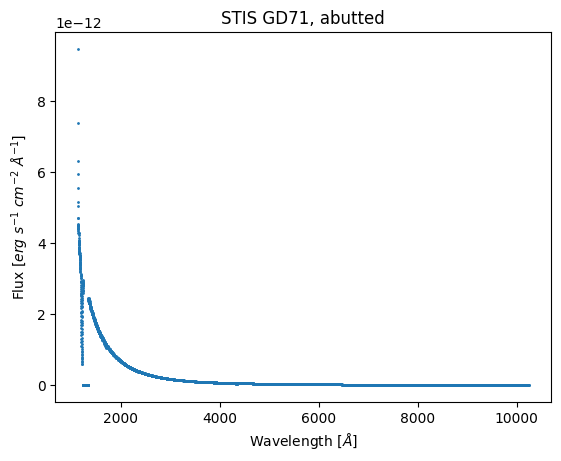

In [13]:
# We are plotting wavelength vs flux for our co-added spectra
# Getting the file's data
gd71_data = fits.open(f"./{stis_products_dir}/{stis_coadd_filename}")[1].data

# Getting the wavelength and flux data for the abutted file
wavelength = gd71_data["WAVELENGTH"]
flux = gd71_data["FLUX"]

# Plotting the spectra
plt.scatter(wavelength, flux,
            # Setting the size of the data points
            s=1)

# Formatting the plot by adding titles
plt.title("STIS GD71, abutted")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

# Saving the figure to the ./stis_products_dir
plt.savefig(f"{stis_products_dir}/gd71_stis.png")

# Showing the plot below
plt.show()

<a id = cos></a>
### 3.3 Putting it all together with COS data

Let's combine all of the STIS work from above and do another example, but this time using COS data instead of STIS. We will use the same target, GD71, and download the data from Program 11479. This has observations of GD71 using the gratings `G230L`, `G185M`, `G225M`, and `G285M`.

In [14]:
# Querying the COS data in MAST and getting the product list
gd71_products = Observations.get_product_list(
    Observations.query_criteria(
        proposal_id=11479,
        target_name="GD71",
        dataproduct_type="SPECTRUM"
    )
)

# Downloading the data to the ./cos_data directory
Observations.download_products(
    gd71_products,
    download_dir=str(cos_data_dir),
    productSubGroupDescription=["X1D", "SX1"]
)

# Consolidating all of our files to a single directory
consolidate_files(cos_data_dir)

 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02d9q/laad02d9q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dcq/laad02dcq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02deq/laad02deq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dgq/laad02dgq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02diq/laad02diq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dkq/laad02dkq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dmq/laad02dmq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02doq/laad02doq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dqq/laad02dqq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dsq/laad02dsq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02duq/laad02duq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dwq/laad02dwq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02dyq/laad02dyq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02e0q/laad02e0q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02e6q/laad02e6q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02e8q/laad02e8q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02eaq/laad02eaq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02edq/laad02edq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02efq/laad02efq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02ehq/laad02ehq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02ejq/laad02ejq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02elq/laad02elq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02enq/laad02enq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02epq/laad02epq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02erq/laad02erq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02etq/laad02etq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02evq/laad02evq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02exq/laad02exq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02ezq/laad02ezq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02f1q/laad02f1q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02f3q/laad02f3q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02f5q/laad02f5q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02f7q/laad02f7q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02fdq/laad02fdq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02ffq/laad02ffq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02fhq/laad02fhq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02foq/laad02foq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02frq/laad02frq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad02fwq/laad02fwq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03vxq/laad03vxq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03vzq/laad03vzq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03w4q/laad03w4q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03w7q/laad03w7q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03w9q/laad03w9q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03wbq/laad03wbq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03wdq/laad03wdq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03wfq/laad03wfq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03wmq/laad03wmq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03woq/laad03woq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03wqq/laad03wqq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03wyq/laad03wyq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03xuq/laad03xuq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03xyq/laad03xyq_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03y0q/laad03y0q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03y3q/laad03y3q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03y5q/laad03y5q_x1d.fits with expected size 429120. [astroquery.query]


 [Done]


INFO: Found cached file cos_data/mastDownload/HST/laad03y7q/laad03y7q_x1d.fits with expected size 429120. [astroquery.query]


Now we run the wrapper script:

In [15]:
!swrapper -i ./cos_data -o ./cos_products

HASP version 0.9.6
Ullyses version 4.1.0


Creating list of unique modes from these files:
./cos_data/laad02d9q_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dcq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02deq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dgq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02diq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dkq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dmq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02doq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dqq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dsq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02duq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dwq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./cos_data/laad02dyq_x1d.fits GD71 COS NUV G225M PSA 11479 (11479, '02')
./c

./cos_data/laad03y3q_x1d.fits GD71 COS NUV G285M PSA 11479 (11479, '03')
./cos_data/laad03y5q_x1d.fits GD71 COS NUV G285M PSA 11479 (11479, '03')
./cos_data/laad03y7q_x1d.fits GD71 COS NUV G285M PSA 11479 (11479, '03')
Looping over visits
Processing product (11479, '02')
Targets in visit (11479, '02'): ['GD71']
Processing target GD71 in visit (11479, '02')
Processing grating COS/G225M
Importing files ['./cos_data/laad02d9q_x1d.fits', './cos_data/laad02dcq_x1d.fits', './cos_data/laad02deq_x1d.fits', './cos_data/laad02dgq_x1d.fits', './cos_data/laad02diq_x1d.fits', './cos_data/laad02dkq_x1d.fits', './cos_data/laad02dmq_x1d.fits', './cos_data/laad02doq_x1d.fits', './cos_data/laad02dqq_x1d.fits', './cos_data/laad02dsq_x1d.fits', './cos_data/laad02duq_x1d.fits', './cos_data/laad02dwq_x1d.fits', './cos_data/laad02dyq_x1d.fits', './cos_data/laad02e0q_x1d.fits', './cos_data/laad02e6q_x1d.fits']
Processing file ./cos_data/laad02d9q_x1d.fits
Processing file ./cos_data/laad02dcq_x1d.fits
Processi

Processing file ./cos_data/laad02doq_x1d.fits
Processing file ./cos_data/laad02dqq_x1d.fits
Processing file ./cos_data/laad02dsq_x1d.fits
Processing file ./cos_data/laad02duq_x1d.fits
Processing file ./cos_data/laad02dwq_x1d.fits


Processing file ./cos_data/laad02dyq_x1d.fits
Processing file ./cos_data/laad02e0q_x1d.fits
Processing file ./cos_data/laad02e6q_x1d.fits
/usr/share/miniconda/lib/python3.11/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_g225m_laad02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g225m_laad02_cspec.fits
Processing grating COS/G185M
Importing files ['./cos_data/laad02e8q_x1d.fits', './cos_data/laad02eaq_x1d.fits', './cos_data/laad02edq_x1d.fits', './cos_data/laad02efq_x1d.fits', './cos_data/laad02ehq_x1d.fits', './cos_data/laad02ejq_x1d.fits', './cos_data/laad02elq_x1d.fits', './cos_data/laad02enq_x1d.fits', './cos_data/laad02epq_x1d.fits', './cos_data/laad02erq_x1d.fits', './cos_data/laad02etq_x1d.fits', './cos_data/laad02evq_x1d.fits', './cos_data/laad02exq_x1d.fits', './cos_data/laad02ezq_x1d.fits', './cos_data/laad02f1q_x1d.fits', './cos_data/laad02f3q_x1d.fits', './cos_data/laad02f5q_x1d.fits']
Processing file ./cos_data/laad02e8q_x1d.fits
Processing file ./cos_data/laad02eaq_x1d.fits
Processing file ./cos_data/laad02edq_x1d.fits
Processing file ./cos_data/laad02efq_x1d.fits
Processing file ./cos_data/laad02

Processing file ./cos_data/laad02elq_x1d.fits
Processing file ./cos_data/laad02enq_x1d.fits
Processing file ./cos_data/laad02epq_x1d.fits
Processing file ./cos_data/laad02erq_x1d.fits
Processing file ./cos_data/laad02etq_x1d.fits
Processing file ./cos_data/laad02evq_x1d.fits


Processing file ./cos_data/laad02exq_x1d.fits
Processing file ./cos_data/laad02ezq_x1d.fits
Processing file ./cos_data/laad02f1q_x1d.fits
Processing file ./cos_data/laad02f3q_x1d.fits
Processing file ./cos_data/laad02f5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_g185m_laad02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g185m_laad02_cspec.fits
Processing grating COS/G285M
Importing files ['./cos_data/laad02f7q_x1d.fits']
Processing file ./cos_data/laad02f7q_x1d.fits
Using a maximum SNR of 20.0 in flux-based filtering
./cos_products/hst_11479_cos_gd71_g285m_laad02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g285m_laad02_cspec.fits
Processing grating COS/G230L
Importing files ['./cos_data/laad02fdq_x1d.fits', './cos_data/laad02ffq_x1d.fits', './cos_data/laad02fhq_x1d.fits', './cos_data/laad02foq_x1d.fits', './cos_data/laad02frq_x1d.fits', './cos_data/laad02fwq_x1d.fits']
Processing file ./cos_data/laad02fdq_x1d.fits


Processing file ./cos_data/laad02ffq_x1d.fits
Processing file ./cos_data/laad02fhq_x1d.fits
Processing file ./cos_data/laad02foq_x1d.fits
Processing file ./cos_data/laad02frq_x1d.fits
Processing file ./cos_data/laad02fwq_x1d.fits
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_cg230l_laad02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_cg230l_laad02_cspec.fits
Making a product from these gratings
COS/G185M 1664-2134 (Actual: 1662.1-2135.4)
COS/G225M 2069-2526 (Actual: 2068.4-2526.4)
COS/G285M 2474-3221 (Actual: 2967.5-3226.9)
COS/G230L 1650-3200 (Actual: 1327.3-3620.0)
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G230L
Abutting COS/G185M product to current result
With a transition wavelength of 1664
Abutting COS/G225M product to current result
With a transition wavelength of 2134
Abutting COS/G230L product to current result
With a transition wavelength of 2526
Abutting COS/G285M product to current result
With a transition wavelength of 2967.5105517364136


Truncating current grating at 3221
./cos_products/hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad02_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad02_cspec.fits
Processing product (11479, '03')
Targets in visit (11479, '03'): ['GD71']
Processing target GD71 in visit (11479, '03')
Processing grating COS/G285M
Importing files ['./cos_data/laad03vxq_x1d.fits', './cos_data/laad03vzq_x1d.fits', './cos_data/laad03w4q_x1d.fits', './cos_data/laad03w7q_x1d.fits', './cos_data/laad03w9q_x1d.fits', './cos_data/laad03wbq_x1d.fits', './cos_data/laad03wdq_x1d.fits', './cos_data/laad03wfq_x1d.fits', './cos_data/laad03wmq_x1d.fits', './cos_data/laad03woq_x1d.fits', './cos_data/laad03wqq_x1d.fits', './cos_data/laad03wyq_x1d.fits', './cos_data/laad03xuq_x1d.fits', './cos_data/laad03xyq_x1d.fits', './cos_data/laad03y0q_x1d.fits', './cos_data/laad03y3q_x1d.fits', './cos_data/laad03y5q_x1d.fits', './cos_data/laad03y7q_x1

Processing file ./cos_data/laad03wdq_x1d.fits
Processing file ./cos_data/laad03wfq_x1d.fits
Processing file ./cos_data/laad03wmq_x1d.fits
Processing file ./cos_data/laad03woq_x1d.fits
Processing file ./cos_data/laad03wqq_x1d.fits
Processing file ./cos_data/laad03wyq_x1d.fits
Processing file ./cos_data/laad03xuq_x1d.fits


Processing file ./cos_data/laad03xyq_x1d.fits
Processing file ./cos_data/laad03y0q_x1d.fits
Processing file ./cos_data/laad03y3q_x1d.fits
Processing file ./cos_data/laad03y5q_x1d.fits
Processing file ./cos_data/laad03y7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_g285m_laad03_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g285m_laad03_cspec.fits
No need to create abutted product as < 2 single grating products
Looping over proposals
Processing product 11479
Targets in proposal 11479: ['GD71']
Processing target GD71 in proposal 11479
Processing grating COS/G225M


Importing files ['./cos_data/laad02d9q_x1d.fits', './cos_data/laad02dcq_x1d.fits', './cos_data/laad02deq_x1d.fits', './cos_data/laad02dgq_x1d.fits', './cos_data/laad02diq_x1d.fits', './cos_data/laad02dkq_x1d.fits', './cos_data/laad02dmq_x1d.fits', './cos_data/laad02doq_x1d.fits', './cos_data/laad02dqq_x1d.fits', './cos_data/laad02dsq_x1d.fits', './cos_data/laad02duq_x1d.fits', './cos_data/laad02dwq_x1d.fits', './cos_data/laad02dyq_x1d.fits', './cos_data/laad02e0q_x1d.fits', './cos_data/laad02e6q_x1d.fits']
Processing file ./cos_data/laad02d9q_x1d.fits
Processing file ./cos_data/laad02dcq_x1d.fits
Processing file ./cos_data/laad02deq_x1d.fits
Processing file ./cos_data/laad02dgq_x1d.fits
Processing file ./cos_data/laad02diq_x1d.fits


Processing file ./cos_data/laad02dkq_x1d.fits
Processing file ./cos_data/laad02dmq_x1d.fits
Processing file ./cos_data/laad02doq_x1d.fits
Processing file ./cos_data/laad02dqq_x1d.fits
Processing file ./cos_data/laad02dsq_x1d.fits


Processing file ./cos_data/laad02duq_x1d.fits
Processing file ./cos_data/laad02dwq_x1d.fits
Processing file ./cos_data/laad02dyq_x1d.fits
Processing file ./cos_data/laad02e0q_x1d.fits
Processing file ./cos_data/laad02e6q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_g225m_laad_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g225m_laad_cspec.fits
Processing grating COS/G185M
Importing files ['./cos_data/laad02e8q_x1d.fits', './cos_data/laad02eaq_x1d.fits', './cos_data/laad02edq_x1d.fits', './cos_data/laad02efq_x1d.fits', './cos_data/laad02ehq_x1d.fits', './cos_data/laad02ejq_x1d.fits', './cos_data/laad02elq_x1d.fits', './cos_data/laad02enq_x1d.fits', './cos_data/laad02epq_x1d.fits', './cos_data/laad02erq_x1d.fits', './cos_data/laad02etq_x1d.fits', './cos_data/laad02evq_x1d.fits', './cos_data/laad02exq_x1d.fits', './cos_data/laad02ezq_x1d.fits', './cos_data/laad02f1q_x1d.fits', './cos_data/laad02f3q_x1d.fits', './cos_data/laad02f5q_x1d.fits']
Processing file ./cos_data/laad02e8q_x1d.fits
Processing file ./cos_data/laad02eaq_x1d.fits


Processing file ./cos_data/laad02edq_x1d.fits
Processing file ./cos_data/laad02efq_x1d.fits
Processing file ./cos_data/laad02ehq_x1d.fits
Processing file ./cos_data/laad02ejq_x1d.fits
Processing file ./cos_data/laad02elq_x1d.fits
Processing file ./cos_data/laad02enq_x1d.fits


Processing file ./cos_data/laad02epq_x1d.fits
Processing file ./cos_data/laad02erq_x1d.fits
Processing file ./cos_data/laad02etq_x1d.fits
Processing file ./cos_data/laad02evq_x1d.fits
Processing file ./cos_data/laad02exq_x1d.fits
Processing file ./cos_data/laad02ezq_x1d.fits
Processing file ./cos_data/laad02f1q_x1d.fits


Processing file ./cos_data/laad02f3q_x1d.fits
Processing file ./cos_data/laad02f5q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_g185m_laad_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g185m_laad_cspec.fits
Processing grating COS/G285M
Importing files ['./cos_data/laad02f7q_x1d.fits', './cos_data/laad03vxq_x1d.fits', './cos_data/laad03vzq_x1d.fits', './cos_data/laad03w4q_x1d.fits', './cos_data/laad03w7q_x1d.fits', './cos_data/laad03w9q_x1d.fits', './cos_data/laad03wbq_x1d.fits', './cos_data/laad03wdq_x1d.fits', './cos_data/laad03wfq_x1d.fits', './cos_data/laad03wmq_x1d.fits', './cos_data/laad03woq_x1d.fits', './cos_data/laad03wqq_x1d.fits', './cos_data/laad03wyq_x1d.fits', './cos_data/laad03xuq_x1d.fits', './cos_data/laad03xyq_x1d.fits', './cos_data/laad03y0q_x1d.fits', './cos_data/laad03y3q_x1d.fits', './cos_data/laad03y5q_x1d.fits', './cos_data/laad03y7q_x1d.fits']
Processing file ./cos_data/laad02f7q_x1d.fits
Processing file ./cos_data/laad03vxq_x1d.fits
Processing file ./cos_data/laad03vzq_x1d.fits
Processing file .

Processing file ./cos_data/laad03w9q_x1d.fits
Processing file ./cos_data/laad03wbq_x1d.fits
Processing file ./cos_data/laad03wdq_x1d.fits
Processing file ./cos_data/laad03wfq_x1d.fits
Processing file ./cos_data/laad03wmq_x1d.fits
Processing file ./cos_data/laad03woq_x1d.fits


Processing file ./cos_data/laad03wqq_x1d.fits
Processing file ./cos_data/laad03wyq_x1d.fits
Processing file ./cos_data/laad03xuq_x1d.fits
Processing file ./cos_data/laad03xyq_x1d.fits
Processing file ./cos_data/laad03y0q_x1d.fits
Processing file ./cos_data/laad03y3q_x1d.fits
Processing file ./cos_data/laad03y5q_x1d.fits


Processing file ./cos_data/laad03y7q_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_g285m_laad_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_g285m_laad_cspec.fits
Processing grating COS/G230L
Importing files ['./cos_data/laad02fdq_x1d.fits', './cos_data/laad02ffq_x1d.fits', './cos_data/laad02fhq_x1d.fits', './cos_data/laad02foq_x1d.fits', './cos_data/laad02frq_x1d.fits', './cos_data/laad02fwq_x1d.fits']
Processing file ./cos_data/laad02fdq_x1d.fits


Processing file ./cos_data/laad02ffq_x1d.fits
Processing file ./cos_data/laad02fhq_x1d.fits
Processing file ./cos_data/laad02foq_x1d.fits
Processing file ./cos_data/laad02frq_x1d.fits
Processing file ./cos_data/laad02fwq_x1d.fits
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L
Segment NUVC removed from product for setting COS/G230L


Using a maximum SNR of 20.0 in flux-based filtering


./cos_products/hst_11479_cos_gd71_cg230l_laad_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_cg230l_laad_cspec.fits
Making a product from these gratings
COS/G185M 1664-2134 (Actual: 1662.1-2135.4)
COS/G225M 2069-2526 (Actual: 2068.4-2526.4)
COS/G285M 2474-3221 (Actual: 2473.8-3226.9)
COS/G230L 1650-3200 (Actual: 1327.3-3620.0)
Starting at the short wavelength end with grating COS/G230L
Abutting COS/G185M product to current result
With a transition wavelength of 1664
Abutting COS/G225M product to current result
With a transition wavelength of 2134
Abutting COS/G285M product to current result
With a transition wavelength of 2526
Truncating current grating at 3221


./cos_products/hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./cos_products/hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad_cspec.fits


Similar to our STIS example, ensure that the filename is updated to the current HASP version by running and/or updating the next cell, then plot the newly abutted COS spectra:

In [16]:
cos_coadd_filename = "hst_11479_cos_gd71_cg230l-g185m-g225m-g285m_laad_cspec.fits"

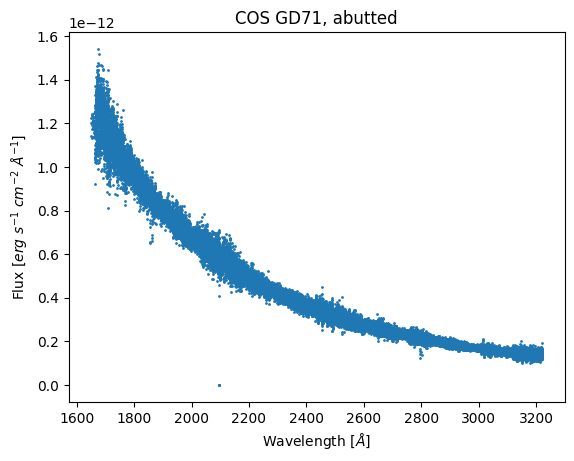

In [17]:
# Getting the file's data
gd71_data = fits.open(f"{cos_products_dir}/{cos_coadd_filename}")[1].data

# Getting the wavelength and flux data for the abutted file
wavelength = gd71_data["WAVELENGTH"]
flux = gd71_data["FLUX"]

# Plotting the spectra
plt.scatter(wavelength, flux,
            s=1)

# Formatting the plot
plt.title("COS GD71, abutted")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

# Saving the figure to ./cos_products
plt.savefig(f"{cos_products_dir}/gd71_cos.png")

# Showing the figure below
plt.show()

We have now created and plotted the abutted COS spectra. Just for fun, let's compare the abutted STIS and COS products!

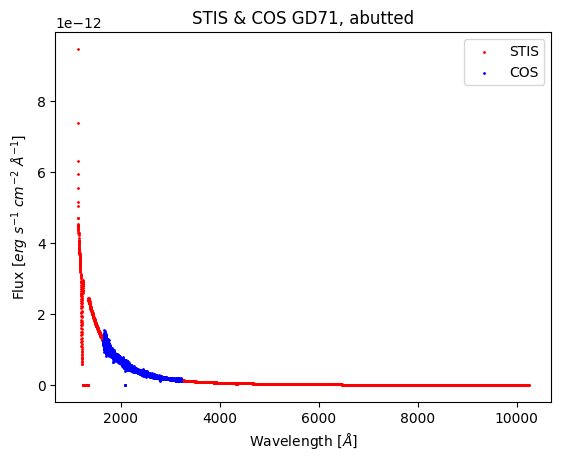

In [18]:
# Getting the COS and STIS data
stis_data = fits.open(f"{stis_products_dir}/{stis_coadd_filename}")[1].data
cos_data = fits.open(f"{cos_products_dir}/{cos_coadd_filename}")[1].data

# Getting the flux and wavelengths for both files
stis_wavelength = stis_data["WAVELENGTH"]
stis_flux = stis_data["FLUX"]

cos_wavelength = cos_data["WAVELENGTH"]
cos_flux = cos_data["FLUX"]

# Plotting datapoints for STIS
plt.scatter(stis_wavelength, stis_flux,
            # Setting the size of the datapoints
            s=1,
            # Setting the color for the STIS datapoints
            color="red",
            # Adding a label for the legend
            label="STIS")

# Plotting the datapoints for COS
plt.scatter(cos_wavelength, cos_flux,
            s=1,
            color="blue",
            label="COS")

# Formatting the plot by adding labels
plt.title("STIS & COS GD71, abutted")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

# Adding a legend to the plot
plt.legend()

# Saving the figure to our general directory
plt.savefig("./gd71_cos_stis.png")

# Showing the plot below
plt.show()

<a id = threshold></a>
## 4. Changing the Threshold Flag

The flux threshold flag is an optional flag that can be used to change the number of files that are co-added based on the flux of each spectra. When determining which files to abut, the script first creates a general co-add using all of the input files, and then iterates through each file to calculate the scaled median deviation. The script rejects a file if: 

$$
\left\langle{\frac{F_{x1d}(i) - F_{coadd(i)}}{\sigma_{x1d}(i)}}\right\rangle{} < \frac{C_{thresh}}{\sqrt{N_{pix}}}
$$

In the equation, the median deviation from the co-add is $F_{x1d}(i) - F_{coadd(i)}$, the uncertainty per
wavelength bin of the input spectrum is $\sigma_{x1d}(i)$ and $N_{pix}$ is the number of wavelength bins for a given mode. Essentially, the scaled median deviation is the dispersion that quantifies the data quality (DQ) flag pixel spread for a spectrum that is less sensitive to outliers and size variations. The script will reject all files containing segments with scaled median deviation less than (i.e. more negative than) the threshold (the default is -50). For example, raising the threshold to -25 will abut less files than the default threshold of -50. Likewise, lowering the threshold to -100 will include more files in the dataset to be co-added. 

An important thing to note about changing the threshold is that including more files increases the SNR of your co-added spectra but decreases the flux accuracy. The threshold value may be altered if a user's science case is not dependent on the accuracy of a dataset's absolute flux. For example, if you have a large dataset of a bright target (i.e. a standard star), then you can lower the threshold to include more files in the abutment since the spread of data quality between each file is minimal. Conversely, if you have a dataset of a dim target, or a dataset with many poor observations, then you will want to raise the threshold to only include the best data out of the dataset.

More information about the flux checking algorithm can be found in [ISR COS 2024-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf).

<a id = downloadthresh></a>
## 4.1 Downloading the Data

We will first download an additional dataset to illustrate how the co-add code changes abutment when the threshold flag is changed. We will download data for the spectroscopic binary, [BD+17D4708](https://simbad.cds.unistra.fr/simbad/sim-coo?Coord=332.88126259897996+18.092873506782&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query&CoordList=) from Program 9631. We will run the script with three different threshold values: `t = -1, -2, -50`.

First we will query and download the data using `Observations` from `astroquery.mast`:

In [19]:
# Querying out data from MAST
bd_query = query = Observations.query_criteria(
            proposal_id=9631,
            target_name="BD+17D4708",
            dataproduct_type="SPECTRUM",
            provenance_name=["CALCOS", "CALSTIS"]
        )

print(f"The number of datasets queried is {str(len(bd_query))} datasets. \
      The query list is printed below:")
print(bd_query)

The number of datasets queried is 12 datasets.       The query list is printed below:
intentType obs_collection provenance_name ... srcDen  obsid     objID  
---------- -------------- --------------- ... ------ -------- ---------
   science            HST         CALSTIS ...    nan 24947039 361629326
   science            HST         CALSTIS ...    nan 24947037 361629331
   science            HST         CALSTIS ...    nan 24947036 361629335
   science            HST         CALSTIS ...    nan 24947038 361629336
   science            HST         CALSTIS ...    nan 24947034 361629339
   science            HST         CALSTIS ...    nan 24947033 361629342
   science            HST         CALSTIS ...    nan 24947031 361629346
   science            HST         CALSTIS ...    nan 24947028 361629348
   science            HST         CALSTIS ...    nan 24947026 361629365
   science            HST         CALSTIS ...    nan 24947027 361629366
   science            HST         CALSTIS ...    n

Let's create a new directory and download our data.

In [20]:
# Creating the data download directories
bd_data_dir = Path("./bd_data/")
bd_products_dir = Path("./bd_products/")

# If the directory doesn't exist, then create it
bd_data_dir.mkdir(exist_ok=True)
bd_products_dir.mkdir(exist_ok=True)

Now we get the product list and download our data to our directory `./bd_products`.

In [21]:
# Getting the product list from our query
bd_prod = Observations.get_product_list(
            bd_query
        )

# Downloading the products, but only the necessary X1D and SX1 files
Observations.download_products(
            bd_prod,
            download_dir=str(bd_data_dir),
            productSubGroupDescription=["X1D", "SX1"]
        )

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str53,str8,object,object
bd_data/mastDownload/HST/o8h101010/o8h101010_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h101020/o8h101020_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h101030/o8h101030_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h101040/o8h101040_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102010/o8h102010_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102020/o8h102020_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102030/o8h102030_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h102040/o8h102040_sx1.fits,COMPLETE,None,None
bd_data/mastDownload/HST/o8h103010/o8h103010_sx1.fits,COMPLETE,None,None


<a id = threshscriptrun></a>
## 4.2 Running the Co-add Script with Different Threshold Values

Let's first organize our data so that all data files are in a single directory instead of separate observation set directories.

In [22]:
consolidate_files(bd_data_dir)

Now that we've downloaded our data and organized it to be properly run by the script, we can run the code using different threshold values. Below is a function that runs the script using inputted threshold values, which will allow us to run the code in a single cell rather than multiple.

In [23]:
def run_script(indir, outdir, thresh):
    '''
    Run the hasp wrapper script with different thresholds.
    -------------------
    Input:
    str indir : Directory that holds all un-abutted data.
    str outdir : Directory that will store output folders and files.
    list thresh : List of threshold values used for script.
    --------------------
    Output:
    Wrapper script is run using different threshold values.
    A folder will be created for each value used, containing abutted products.
    '''
    # Looping through thresh vals to run through script
    for val in thresh:
        # Creating a folder for each thresh val
        output = os.path.join(outdir, "out" + str(val))
        if not os.path.exists(output):
            os.mkdir(output)

        print(f"Running script where threshold = {str(val)}")

        # Specifying the arguments for the scipt
        arguments = ["-i", indir, "-o", output, "-t", val]

        # Creating a list composed of the script commands and arguments
        command = ["python", "-m", "hasp.wrapper"] + arguments

        # Running the script with the arguments above
        subprocess.run(command, check=True)

Let's create a variable called `thresholds` that will consist of the different threshold values that we will use to help us visualize the relationship between number of files co-added and the final co-added product. We will run the script using each of these values.

*Note: feel free to run the cells with more threshold values!*

In [24]:
# Remember that the default value is t = -50
thresholds = ["-1", "-2", "-50"]

Let's run the script on our data now using the `run_script` function, using the thresholds defined above.

In [25]:
run_script(bd_data_dir, bd_products_dir, thresholds)

Running script where threshold = -1


HASP version 0.9.6
Ullyses version 4.1.0
Creating list of unique modes from these files:
bd_data/o8h101010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '01')
bd_data/o8h101020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '01')
bd_data/o8h101030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '01')
bd_data/o8h101040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '01')
bd_data/o8h102010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '02')
bd_data/o8h102020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '02')
bd_data/o8h102030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '02')
bd_data/o8h102040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '02')
bd_data/o8h103010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '03')
bd_data/o8h103020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '03')
bd_data/o8h103030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '03')
bd_data/o8h103040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (96

bd_products/out-1/hst_9631_stis_bdp17d4708_g230lb-g430l-g750l_o8h103_cspec.fits already exists and overwrite=False, skipping write
   Wrote bd_products/out-1/hst_9631_stis_bdp17d4708_g230lb-g430l-g750l_o8h103_cspec.fits
Looping over proposals
Processing product 9631
Targets in proposal 9631: ['BD+17D4708']
Processing target BD+17D4708 in proposal 9631
Processing grating STIS/G430L
Importing files ['bd_data/o8h101010_sx1.fits', 'bd_data/o8h101020_sx1.fits', 'bd_data/o8h102010_sx1.fits', 'bd_data/o8h102020_sx1.fits', 'bd_data/o8h103010_sx1.fits', 'bd_data/o8h103020_sx1.fits']
Processing file bd_data/o8h101010_sx1.fits
Processing file bd_data/o8h101020_sx1.fits
Processing file bd_data/o8h102010_sx1.fits
Processing file bd_data/o8h102020_sx1.fits
Processing file bd_data/o8h103010_sx1.fits
Processing file bd_data/o8h103020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
Segment #0 from file bd_data/o8h101010_sx1.fits has scaled median = -4.852887374265663
Removing file bd_data/

HASP version 0.9.6
Ullyses version 4.1.0
Creating list of unique modes from these files:
bd_data/o8h101010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '01')
bd_data/o8h101020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '01')
bd_data/o8h101030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '01')
bd_data/o8h101040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '01')
bd_data/o8h102010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '02')
bd_data/o8h102020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '02')
bd_data/o8h102030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '02')
bd_data/o8h102040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '02')
bd_data/o8h103010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '03')
bd_data/o8h103020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '03')
bd_data/o8h103030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '03')
bd_data/o8h103040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (96

Processing grating STIS/G430L
Importing files ['bd_data/o8h101010_sx1.fits', 'bd_data/o8h101020_sx1.fits', 'bd_data/o8h102010_sx1.fits', 'bd_data/o8h102020_sx1.fits', 'bd_data/o8h103010_sx1.fits', 'bd_data/o8h103020_sx1.fits']
Processing file bd_data/o8h101010_sx1.fits
Processing file bd_data/o8h101020_sx1.fits
Processing file bd_data/o8h102010_sx1.fits
Processing file bd_data/o8h102020_sx1.fits
Processing file bd_data/o8h103010_sx1.fits
Processing file bd_data/o8h103020_sx1.fits
Using a maximum SNR of 20.0 in flux-based filtering
Segment #0 from file bd_data/o8h101010_sx1.fits has scaled median = -4.852887374265663
Removing file bd_data/o8h101010_sx1.fits from product
Segment #0 from file bd_data/o8h102010_sx1.fits has scaled median = -3.759874284435761
Removing file bd_data/o8h102010_sx1.fits from product
Importing files ['bd_data/o8h101020_sx1.fits', 'bd_data/o8h102020_sx1.fits', 'bd_data/o8h103010_sx1.fits', 'bd_data/o8h103020_sx1.fits']
Processing file bd_data/o8h101020_sx1.fits
P

HASP version 0.9.6
Ullyses version 4.1.0
Creating list of unique modes from these files:
bd_data/o8h101010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '01')
bd_data/o8h101020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '01')
bd_data/o8h101030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '01')
bd_data/o8h101040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '01')
bd_data/o8h102010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '02')
bd_data/o8h102020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '02')
bd_data/o8h102030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '02')
bd_data/o8h102040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (9631, '02')
bd_data/o8h103010_sx1.fits BD+17D4708 STIS CCD G430L 52X2E1 9631 (9631, '03')
bd_data/o8h103020_sx1.fits BD+17D4708 STIS CCD G430L 52X2 9631 (9631, '03')
bd_data/o8h103030_sx1.fits BD+17D4708 STIS CCD G230LB 52X2 9631 (9631, '03')
bd_data/o8h103040_sx1.fits BD+17D4708 STIS CCD G750L 52X2 9631 (96

<a id = analyzethresh></a>
## 4.3 Analyzing the Different Co-added Spectra of Different Threshold Values

Now that we've run the script on our dataset using differnet threshold values, we can start to analyze the differences between them. 

The `run_script` function created multiple folders for the abutted products; one folder for each threshold value (ex. `./out-50`). In each folder is the fully co-added spectra. At the time of this notebook, the fully co-added filename is:

`hst_9631_stis_bdp17d4708_g230lb-g430l-g750l_o8h1_cspec.fits`
 
Before you continue, make sure that the fully co-added filename is valid, as the filenaming structure may have changed since this notebook was published. Update and run the cell below.

In [26]:
bd_coadd_name = "hst_9631_stis_bdp17d4708_g230lb-g430l-g750l_o8h1_cspec.fits"

We can see how many files were used in the co-add by running next the cell.

In [27]:
# Iterating through the threshold values
for thresh in thresholds:
    # Path to the co-added file
    path_to_coadd = f"{bd_products_dir}/out{thresh}/{bd_coadd_name}"

    # Opening the file to check num files, and printing
    numfiles = len(fits.open(path_to_coadd)[2].data["FILENAME"])

    # Printing the number of files for the given threshold value
    print(f"The number of files co-added for t = {thresh} is {numfiles} files")

The number of files co-added for t = -1 is 6 files
The number of files co-added for t = -2 is 9 files
The number of files co-added for t = -50 is 12 files


As we can see, as we increase the threshold value (`t = -50` -> `t = -1`) we went from 12 files being used to only 6. Since we are using more data with the lower threshold (`t = -50`), we should see an increase in SNR.

### Looking at SNR:

We'll plot the SNR of both coadds below. 

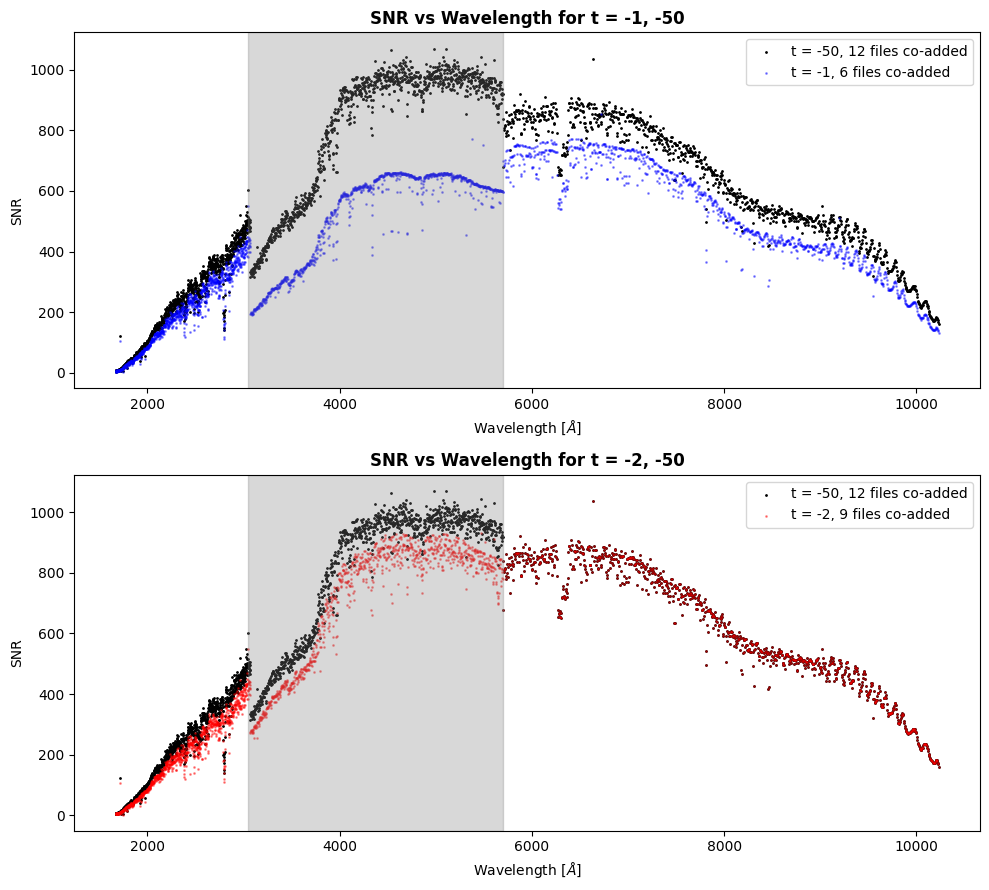

In [28]:
# A list of the the non-default thresholds used.
nondefault_thresholds = [thresh for thresh in thresholds if thresh != "-50"]

# List of colors to be used when plotting
colors = ['blue',
          'red']

# Creating our figure: 1 column and len(thresholds) rows
figure, ax = plt.subplots(len(nondefault_thresholds), 1,
                          figsize=(10, 9))

# Iterating through threshold values to compare their SNR to default output
for i, thresh in enumerate(nondefault_thresholds):

    # The SNR and wavelength data for the default threshold co-add output
    default_path = f"{bd_products_dir}/out-50/{bd_coadd_name}"
    data50 = fits.open(default_path)[1].data
    wavelength50 = data50["WAVELENGTH"]
    snr50 = data50["SNR"]

    # Getting wavelength and SNR for the current iteration's threshold value
    curr_path = f"{bd_products_dir}/out{thresh}/{bd_coadd_name}"
    data = fits.open(curr_path)[1].data
    wavelength = data["WAVELENGTH"]
    snr = data["SNR"]

    # This is the number of files used in the particular co-add
    numfiles = len(fits.open(curr_path)[2].data["FILENAME"])
    numfiles_default = len(fits.open(default_path)[2].data["FILENAME"])

    ax[i].scatter(wavelength50, snr50,
                  label=f"t = -50, {numfiles_default} files co-added",
                  s=1,
                  color="black")

    ax[i].scatter(wavelength, snr,
                  label=f"t = {thresh}, {numfiles} files co-added",
                  color=colors[i],
                  s=1,
                  alpha=0.4)

    ax[i].legend()

    # Highlighting the region of the plot with the biggest SNR change
    ax[i].axvspan(3050, 5700,
                  alpha=0.3,
                  color="grey")

    # Adding formatting
    ax[i].set_title(f"SNR vs Wavelength for t = {thresh}, -50",
                    weight="bold")
    ax[i].set_xlabel(r'Wavelength [$\AA$]')
    ax[i].set_ylabel("SNR")

figure.tight_layout()

# Saving the figure to ./bd_products
figure.savefig(f"{bd_products_dir}/snr_wavelength.png")

We can clearly see above that using more files in the co-add substantially increases SNR. This is especially prevalent in the grey highlighted section of the top plot, where we set `t = -1`. The number of files used with that threshold value were 6 files, whereas the default threshold value of `t = -50` used 12 files.

### Looking at Flux:
We're going to create two diffrent plots to analyze our flux data: a standard flux vs wavelength plot, and a differential plot. We will also calculate the percent change in flux between the threshold values vs the default.

A differential plot shows the absolute differences between two datasets; in our case, we will be seeing the flux difference at each wavelength between one threshold value's co-add and the default co-add. However, we will first need to interpolate the spectra to a common wavelength grid. Essentially, we will be adjusting the wavelength values so the two datasets can share the same wavelength points. 

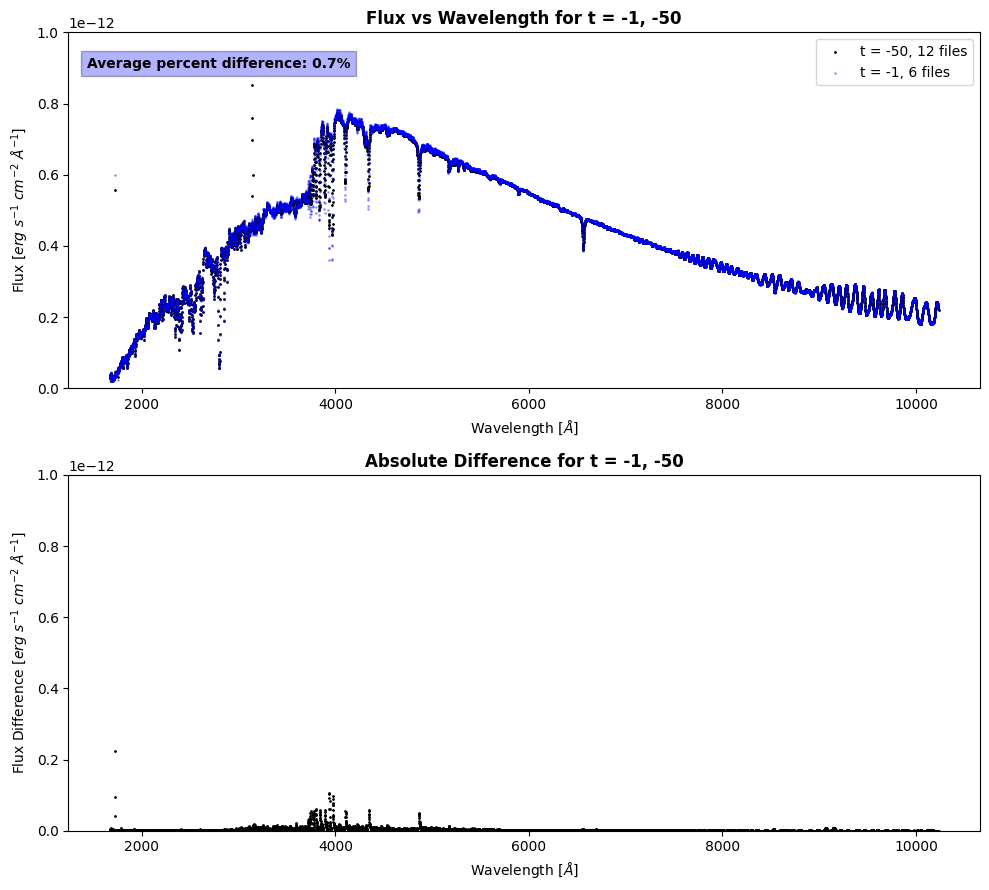

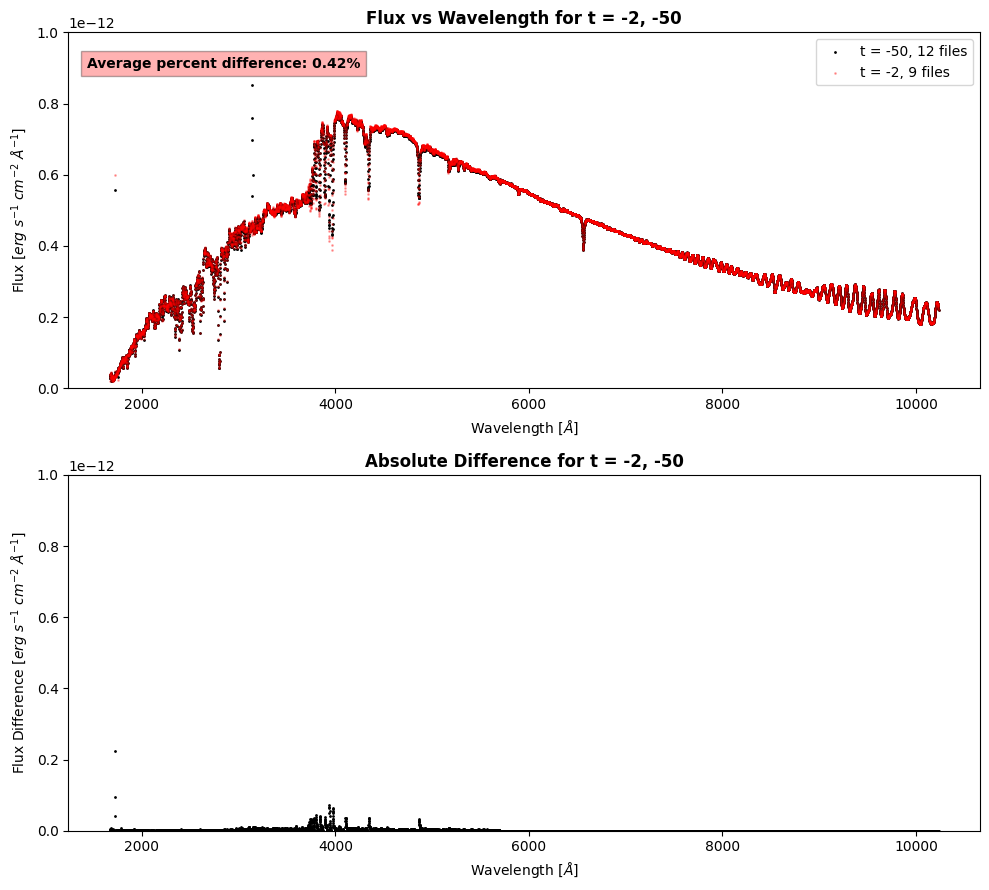

In [29]:
# Thresholds used that aren't the default
nondefault_thresholds = [thresh for thresh in thresholds if thresh != "-50"]

for i, thresh in enumerate(nondefault_thresholds):
    # Getting the data for the co-add that uses default threshold of t = -50
    default_path = f"{bd_products_dir}/out-50/{bd_coadd_name}"
    thresh_data50 = fits.open(default_path)[1].data

    wavelength50 = thresh_data50["WAVELENGTH"]
    flux50 = thresh_data50["FLUX"]

    # Getting data for the co-add that uses the current iteration's threshold
    curr_path = f"{bd_products_dir}/out{thresh}/{bd_coadd_name}"
    thresh_data_curr = fits.open(curr_path)[1].data

    wavelength_curr = thresh_data_curr["WAVELENGTH"]
    flux_curr = thresh_data_curr["FLUX"]

    # Getting the number of files used in co-add, will put this in the plot
    numfiles = len(fits.open(curr_path)[2].data["FILENAME"])
    numfiles_default = len(fits.open(default_path)[2].data["FILENAME"])

    # Minimum wavelength value in dataset
    minwave = min(wavelength50[0].min(), wavelength_curr[0].min())

    # Maximum wavelength value in dataset
    maxwave = max(wavelength50[0].max(), wavelength_curr[0].max())

    # Creating a common wavelength grid using shape of default wavelength axis
    common_wavelength = np.arange(start=minwave,
                                  stop=maxwave,
                                  step=1)

    # Interpolating the default + current threshold co-add onto new grid
    interp_flux50 = interp1d(wavelength50[0],
                             flux50,
                             kind='linear',
                             fill_value="extrapolate")(common_wavelength)
    
    interp_flux_curr = interp1d(wavelength_curr[0],
                                flux_curr,
                                kind='linear',
                                fill_value="extrapolate")(common_wavelength)

    # Creating two subplots, one flux vs wavelength and one differential plot
    fig, [ax0, ax1] = plt.subplots(2, 1,
                                   figsize=(10, 9))

    # Plotting the top plot, a.k.a. the flux vs wavelength for t = -50
    ax0.scatter(common_wavelength, interp_flux50,
                label=f"t = -50, {numfiles_default} files",
                color="black",
                s=1)

    # Plotting flux vs wavelength on same plot for current co-add
    ax0.scatter(common_wavelength, interp_flux_curr,
                label=f"t = {thresh}, {numfiles} files",
                color=colors[i],
                s=1,
                alpha=0.3)

    # Calculating difference between current co-add and default flux values
    flux_diff = interp_flux_curr - interp_flux50

    # Plotting the differential plot
    ax1.scatter(common_wavelength, flux_diff,
                color="black",
                s=1)

    # Calculating the percent difference and putting it on the plot
    percent_difference = abs(interp_flux50 - interp_flux_curr) / ((interp_flux50 + interp_flux_curr) / 2) * 100

    # Calculating the mean percent difference (ignoring NaNs)
    percent_difference = round(np.nanmean(percent_difference), 2)

    # Adding text box onto plot that displays newly calculated 5 difference
    ax0.text(0.02, 0.9,
             f"Average percent difference: {str(percent_difference)}%",
             transform=ax0.transAxes,
             weight="bold",
             bbox=dict(facecolor=colors[i],
                       alpha=0.3))
    
    # Setting the y axis limits on both plots to be the same
    ax0.set_ylim(0, 1e-12)
    ax1.set_ylim(0, 1e-12)

    # Adding formatting
    ax0.set_title(f"Flux vs Wavelength for t = {thresh}, -50",
                  weight="bold")

    ax0.set_xlabel(r'Wavelength [$\AA$]')
    ax0.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    # Putting the legend on the flux plot
    ax0.legend()

    ax1.set_title(f"Absolute Difference for t = {thresh}, -50",
                  weight="bold")
    
    ax1.set_xlabel(r'Wavelength [$\AA$]')
    ax1.set_ylabel(r'Flux Difference [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    fig.tight_layout()

    fig.savefig(f"{bd_products_dir}/flux_differential.png")

    fig.show()

# Congrats on completing the notebook!

### There are more tutorial notebooks for custom co-addition cases in [this repo](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP), check them out!

## About this Notebook
**Author:** Sierra Gomez (sigomez@stsci.edu)

**Updated on:** 01/02/2024

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*


## Citations

If you use the following packages for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)

* [Citing `scipy`](https://scipy.org/citing-scipy/)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>